In [692]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

train_data = pd.read_csv('dataset/price_data_tr.csv')
heldout_data = pd.read_csv('dataset/price_data_val.csv')
test_data = pd.read_csv('dataset/price_data_ts.csv')

In [693]:
print(train_data.shape)
print(heldout_data.shape)
print(test_data.shape)

(12968, 21)
(4323, 21)
(4322, 21)


In [694]:
# data.columns
# 'id', 'date', 
# 'price', 
# 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
# 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'

In [695]:
print(train_data.iloc[0:2, [0,1,2,3]])
print(heldout_data.iloc[0:2, [0,1,2,3]])
print(test_data.iloc[0:2, [0,1,2,3]])

           id             date     price  bedrooms
0  1310440590  20150413T000000  440000.0         3
1  1437580480  20140918T000000  994000.0         5
           id             date     price  bedrooms
0  7229800175  20140604T000000  453500.0         5
1  3905080870  20150206T000000  510000.0         3
           id             date  price  bedrooms
0  7000100850  20140926T000000    NaN         4
1  4037400280  20140923T000000    NaN         3


In [696]:
nor_train = train_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))
nor_heldout = heldout_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))
nor_test = test_data.iloc[:, 3:-1].apply(lambda x: (x-x.mean()) / (x.std()))

train_price = train_data.iloc[:, 2:3]
heldout_price = heldout_data.iloc[:, 2:3]

In [697]:
train_label_mean, train_label_std = train_data.iloc[:, 2].mean(), train_data.iloc[:, 2].std()
heldout_label_mean, heldout_label_std = heldout_data.iloc[:, 2].mean(), heldout_data.iloc[:, 2].std()
print(train_label_mean, train_label_std)
print(heldout_label_mean, heldout_label_std)

uni_label_mean = pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2])).mean()
uni_label_std = pd.concat((train_data.iloc[:, 2], heldout_data.iloc[:, 2])).std()
print(uni_label_mean, uni_label_std)

538744.5078655151 361988.18319089006
542645.3518390007 367635.16162767523
539719.7752588051 363401.4889145882


In [698]:
train_feats = torch.tensor(nor_train.iloc[:, :].values, dtype=torch.float32)
train_labels = torch.tensor(train_price.values.reshape(-1, 1), dtype=torch.float32)

heldout_feats = torch.tensor(nor_heldout.iloc[:, :].values, dtype=torch.float32)
heldout_labels = torch.tensor(heldout_price.values.reshape(-1, 1), dtype=torch.float32)

test_feat = torch.tensor(nor_test.iloc[:, :].values, dtype=torch.float32)

In [699]:
print(train_feats.shape)
print(train_labels.shape)
print(heldout_feats.shape)
print(heldout_labels.shape)
print(test_feat.shape)

torch.Size([12968, 17])
torch.Size([12968, 1])
torch.Size([4323, 17])
torch.Size([4323, 1])
torch.Size([4322, 17])


In [700]:
n_train, in_features = train_data.shape[0], train_feats.shape[1]


class Regressor(nn.Module):
    def __init__(self):
        super(Regressor, self).__init__()
        self.fc1 = nn.Linear(in_features, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 16)
        self.fc6 = nn.Linear(16, 1)
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU() # trial 5
#         self.relu = nn.PReLU() # trial 3, 6
#         self.relu = nn.SELU() # trial 4, 7
#         self.relu = nn.Tanh() # trial 8
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc4(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc5(x)
        x = self.relu(x)
#         x = self.dropout(x) # trial 2 유 / 5,6,7 무
        
        x = self.fc6(x)
        return x
    
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [701]:
learning_rate = 0.01
weight_decay = 0.1
batch_size = 512
epochs = 800

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = Regressor().to(device)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
optimizer = torch.optim.AdamW(net.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100,200,300,400,500,600], gamma=0.25)
# optimizer = torch.optim.Adagrad(net.parameters(), lr=learning_rate, lr_decay=0, weight_decay=weight_decay, initial_accumulator_value=0, eps=1e-10)

In [702]:
train_features, train_labels  = train_feats.to(device), train_labels.to(device)
test_features, test_labels = heldout_feats.to(device), heldout_labels.to(device)

dataset = TensorDataset(train_features, train_labels)
dataloader = DataLoader(dataset, batch_size=batch_size)

train_ls, test_ls = [], []

for epoch in range(epochs):
    for inputs, labels in dataloader:
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
    
    train_rmse = np.sqrt(criterion(net(train_features), train_labels).item())
    test_rmse = np.sqrt(criterion(net(test_features), test_labels).item())
    
    train_ls.append(train_rmse)
    test_ls.append(test_rmse)

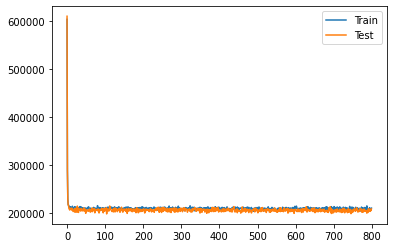

210744.4687, 208939.5249


In [711]:
plt.plot(train_ls, label="Train")
plt.plot(test_ls, label="Test")
plt.legend()
plt.show()

print(f'{train_ls[-1]:0.4f}, {test_ls[-1]:0.4f}')

In [704]:
predicts = net(test_features).to('cpu').detach().numpy()
rmse_train = rmse(predicts, test_labels.to('cpu').detach().numpy())
print(predicts)
print(rmse_train)

[[380904.88]
 [432483.28]
 [564362.8 ]
 ...
 [198910.47]
 [423697.12]
 [582051.  ]]
201770.16


In [705]:
test_predicts = net(test_feat.to('cuda'))
test_predicts

tensor([[338090.0625],
        [376634.8438],
        [240136.3750],
        ...,
        [915810.1875],
        [387687.3750],
        [399746.4688]], device='cuda:0', grad_fn=<AddmmBackward>)

In [689]:
test_data = pd.read_csv('dataset/price_data_ts.csv')
test_data['price'] = test_predicts

test_data['id'] = test_data['id'].apply(lambda x : str(x) if len(str(x)) == 10 else '0' + str(x) if len(str(x)) == 9 else '00' + str(x))
submission['id'] = test_data['id'].astype(str) + test_data['date'].astype(str)
submission = pd.concat([submission['id'], test_data['price']], axis=1)
submission

,id,price
0,700010085020140926T000000,1.261811e+11
1,403740028020140923T000000,9.064385e+10
2,142340016020140618T000000,1.226681e+11
3,776740006020141119T000000,1.808352e+11
4,946590050020140617T000000,2.624662e+11
...,...,...
4317,733822037020141006T000000,2.050755e+11
4318,681910015020140721T000000,2.406491e+11
4319,082405914020140527T000000,2.582378e+11
4320,051450009020140513T000000,2.403824e+11


In [690]:
submission.to_csv('submission.csv', index=False)